# Dog Breed Classifier
- In this jupyter notebook, I have used transfer learning to classify dog images into 133 dog breeds
- EfficientNetB4 model is trained in this notebook

### Import Section

In [1]:
import os
import cv2
import glob
import math
import pathlib
from zipfile import ZipFile
from struct import unpack

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, confusion_matrix, recall_score,
                             f1_score, classification_report)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(45)
tf.random.set_seed(123)

### Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define some global variables

In [3]:
TARGET_SIZE = 300
BATCH_SIZE = 20
BUFFER_SIZE = 1024
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

### Extract zipped data

In [4]:
# path of data directory
DATA_DIR = '/content/drive/MyDrive/Dog Breeds/DogBreeds.zip'

# data extraction directory
EXTRACT_DIR = '/tmp'

# extract data into EXTRACT_DIR
with ZipFile(DATA_DIR, 'r') as ref:
  ref.extractall(EXTRACT_DIR)

# list the contents of the EXTRACT_DIR
os.listdir(EXTRACT_DIR)

['debugger_1rrdvwptn0',
 'initgoogle_syslog_dir.0',
 'dap_multiplexer.383f006c5abc.root.log.INFO.20210711-072722.51',
 'tmpxzeui6je',
 'drivefs_ipc.0',
 'drivefs_ipc.0_shell',
 'dap_multiplexer.INFO',
 'dogImages']

In [5]:
# list the contents of the dogImages directory
os.listdir(EXTRACT_DIR + '/dogImages')

['valid', 'test', 'train']

### Data Preparation
- Helper function to construct dataframe of image file paths and labels

In [6]:
def get_dataframe(data_path, get_class_names = False, dtype = None):
  """
  Constructs dataframe from image file paths and class labels

  Args:
    data_path (string): path of image data
    get_class_names (bool): return class names if True
    dtype: indicates train/validation/test data

  Returns:
    df: dataframe
    class_names: name of classes
  """
  labels = []   # store labels
  file_paths = []   # store image file paths

  # iterate over the dog breeds
  for class_name in os.listdir(data_path):
    # extract the breed name
    breed_name = class_name.split('.')[1]
    # construct path for the given dog breed
    breed_path = os.path.join(data_path, class_name)

    # iterate over the images in the given dog breed
    for file_path in os.listdir(breed_path):
      # append the breed name
      labels.append(breed_name)
      # append the image file path
      file_paths.append(os.path.join(breed_path, file_path))

  # unique breed names 
  class_names = np.unique(labels).tolist()

  # construct dataframe from file_paths and labels
  df = pd.DataFrame({'file_paths': file_paths, 'classes': labels})

  # add column with integer labels
  df['labels'] = df['classes'].apply(lambda x: class_names.index(x))

  # print the number of images
  print(f'Number of images in the {dtype} data: {df.shape[0]}')
  
  if get_class_names:
    return class_names, df 

  else:
    return df

#### Get training, validation and test dataframes

In [7]:
# training dataframe
CLASS_NAMES, train_df = get_dataframe(EXTRACT_DIR + '/dogImages/train',
                                      dtype = 'training',
                                      get_class_names = True)

# validation dataframe
val_df = get_dataframe(EXTRACT_DIR + '/dogImages/valid', 
                       dtype = 'validation')

# test dataframe
test_df = get_dataframe(EXTRACT_DIR + '/dogImages/test', 
                        dtype = 'test')

# print the head of train_df
train_df.head()

Number of images in the training data: 6680
Number of images in the validation data: 835
Number of images in the test data: 836


,file_paths,classes,labels
0,/tmp/dogImages/train/012.Australian_shepherd/A...,Australian_shepherd,11
1,/tmp/dogImages/train/012.Australian_shepherd/A...,Australian_shepherd,11
2,/tmp/dogImages/train/012.Australian_shepherd/A...,Australian_shepherd,11
3,/tmp/dogImages/train/012.Australian_shepherd/A...,Australian_shepherd,11
4,/tmp/dogImages/train/012.Australian_shepherd/A...,Australian_shepherd,11


#### Remove corrupt images from the dataset
- some images in the dataset are corrupted


In [8]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

In [9]:
# JPEG class
class JPEG:
    def __init__(self, image_file):
      """
      Reads the image from the image_file path
      """
      with open(image_file, 'rb') as f:
          self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data) == 0:
                break     

In [10]:
# The code below removes these corrupted images from the dataset
def corrupt_images(df, dtype = None):
  """
  Removes the corrupted image file paths from the dataframe

  Args:
    df: dataframe of image file paths and labels

  Returns:
    df: dataframe with no corrupt image file paths and labels
  """
  corrupt_img_list = []
  # iterate over the image file paths in the dataframe
  for img in tqdm(df.file_paths.values):
    image = JPEG(img) 
    try:
      image.decode()   
    except:
      corrupt_img_list.append(img)

  df = df[~df.file_paths.isin(corrupt_img_list)]
  print(f'Number of images in the {dtype} data: {df.shape[0]}')
  return df  

In [11]:
# removing corrupt images from the training, validation and test dataframes
train_df = corrupt_images(train_df, dtype = 'training')
val_df = corrupt_images(val_df, dtype = 'validation')
test_df = corrupt_images(test_df, dtype = 'test')

  0%|          | 0/836 [00:00<?, ?it/s]

Number of images in the training data: 6659
Number of images in the validation data: 832


100%|██████████| 836/836 [00:00<00:00, 5611.44it/s]

Number of images in the test data: 832


#### Image-label pairs
- Helper functions to prepare image-label pairs

In [12]:
def decode_image(image):
  # convert the compressed string to a 3D uint8 tensor
  image = tf.image.decode_jpeg(image, channels = 3)
  image = tf.cast(image, tf.float32) 
  # resize the image to the desired size
  image = tf.image.resize(image, [TARGET_SIZE, TARGET_SIZE])
  return image


def process_path(file_path, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_image(img)
  return img, label

#### TensorFlow datasets (tf.data.Dataset pipeline)

In [13]:
def get_dataset(image_paths, image_labels, batch_size = BATCH_SIZE, repeated = False, cached = False):
  """
  Return a Tensorflow dataset ready for training or inference
    
  Args:
    image_paths (string): path of image files
    image_labels (string): class names
    batch_size (int): batch size to be used
    repeated (bool): repeat the dataset if True
    cached (bool): cache the dataset if True
    augment (bool): augment the dataset if True

  Returns: 
    dataset: tf.data.Dataset object
  """
  # create image-label pair dataset
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
  dataset = dataset.shuffle(buffer_size = BUFFER_SIZE)
  
  # Set `num_parallel_calls` so multiple images are loaded/processed in parallel
  dataset = dataset.map(process_path, num_parallel_calls = AUTOTUNE)
  
  if repeated:
    dataset = dataset.repeat()
      
  dataset = dataset.batch(BATCH_SIZE)
  
  if cached:
    dataset = dataset.cache()

  dataset = dataset.prefetch(AUTOTUNE)
  
  return dataset

#### Get training, validation and test datasets


In [14]:
# training dataset
train_ds = get_dataset(train_df.file_paths.values, train_df.labels.values)

# validation dataset
val_ds = get_dataset(val_df.file_paths.values, val_df.labels.values)

# test dataset
test_ds = get_dataset(test_df.file_paths.values, test_df.labels.values)

### Display few images from the training dataset

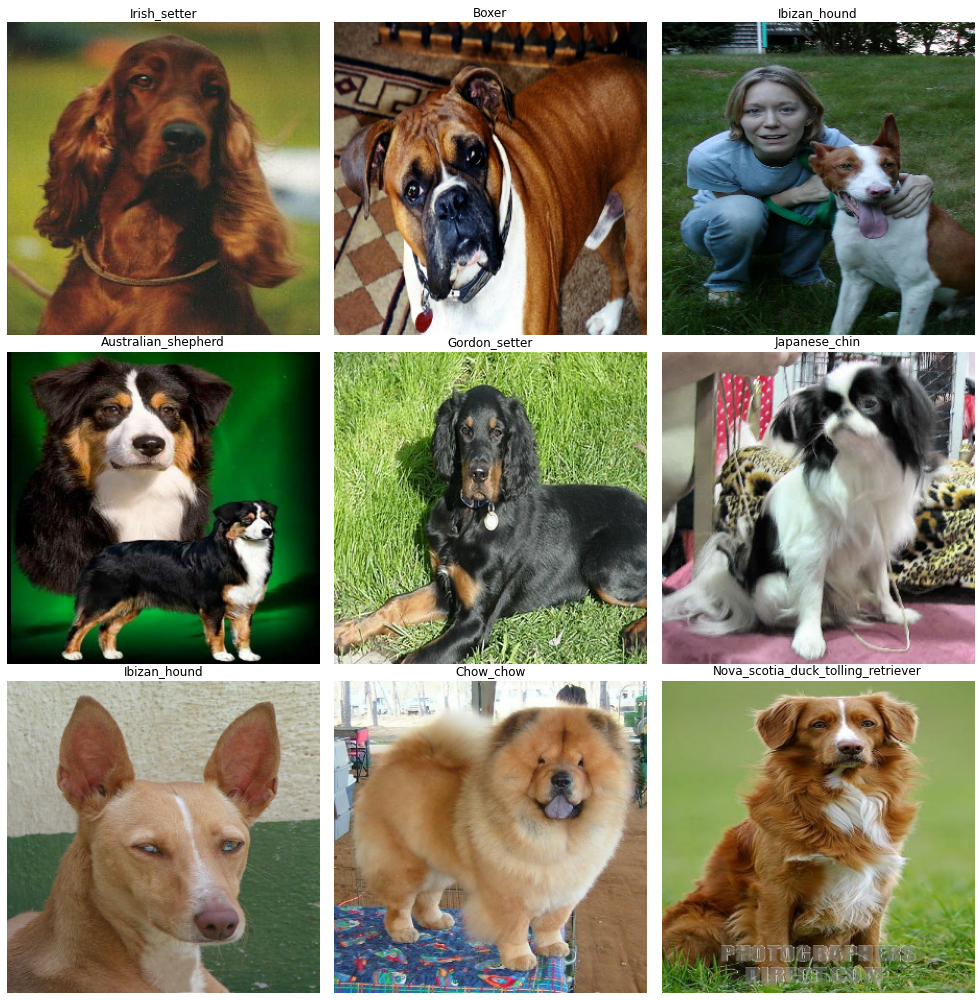

In [15]:
# get a batch from the training dataset
image_batch, label_batch = next(iter(train_ds))

# create figure object
fig = plt.figure(figsize = (14, 14))
for i in range(9):
  # fig.add_subplot(3, 3, i + 1)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(CLASS_NAMES[label])
  plt.axis("off")
plt.tight_layout(w_pad = 0.1, h_pad = 0.1)

### Plot loss and accuracy
- Helper function to plot loss and accuracy curves

In [16]:
def plot_loss_accuracy(history):
  """
  This function plots the loss and accuracy of the model on training and validation data

  Args:
    history: training history of the model
    model_name (string): name of the model
    epochs (int): number of epochs 

  Returns: 
    None
  """
  epochs = len(history.history['loss'])
  # create figure object
  fig, ax = plt.subplots(1, 2, figsize = (15, 6))

  # plot training and validation loss
  ax[0].plot(range(1, epochs + 1), history.history['loss'])
  ax[0].plot(range(1, epochs + 1), history.history['val_loss'])
  ax[0].set_title(f'Training and validation loss curve')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend(['train', 'val'])

  # plot training and validation accuracy
  ax[1].plot(range(1, epochs + 1), history.history['accuracy'])
  ax[1].plot(range(1, epochs + 1), history.history['val_accuracy'])
  ax[1].set_title(f'Training and validation accuracy curve')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend(['train', 'val']);

### Build model

In [19]:
# load the pre-trained InceptionV3 model
base_model = tf.keras.applications.EfficientNetB4(weights = 'imagenet', 
                                                  include_top = False, 
                                                  input_shape = (300, 300, 3))
# freeze all convolutional layers
base_model.trainable = False

# add a global spatial average pooling layer
x = layers.GlobalAveragePooling2D(name = 'gpool')(base_model.output)

# add a dropout layer to avoid overfitting
x = layers.Dropout(0.3, name = 'dropout')(x)

# output layer with 37 classes
x = layers.Dense(len(CLASS_NAMES), activation = 'softmax', name = 'output')(x)

# final model
model = tf.keras.Model(base_model.inputs, x, name = 'EfficientNetB4')
    
# print the model summary
model.summary()

Model: "EfficientNetB4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 300, 300, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 300, 300, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

### Compile and fit the model

Epoch 1/50
333/333 [==============================] - 114s 225ms/step - loss: 2.1211 - accuracy: 0.6198 - val_loss: 0.9753 - val_accuracy: 0.7488
Epoch 2/50
333/333 [==============================] - 70s 209ms/step - loss: 0.5108 - accuracy: 0.8677 - val_loss: 0.5513 - val_accuracy: 0.8317
Epoch 3/50
333/333 [==============================] - 70s 209ms/step - loss: 0.3180 - accuracy: 0.9076 - val_loss: 0.4281 - val_accuracy: 0.8582
Epoch 4/50
333/333 [==============================] - 73s 218ms/step - loss: 0.2355 - accuracy: 0.9348 - val_loss: 0.3798 - val_accuracy: 0.8666
Epoch 5/50
333/333 [==============================] - 70s 209ms/step - loss: 0.1852 - accuracy: 0.9474 - val_loss: 0.3671 - val_accuracy: 0.8738
Epoch 6/50
333/333 [==============================] - 72s 217ms/step - loss: 0.1592 - accuracy: 0.9552 - val_loss: 0.3800 - val_accuracy: 0.8762
Epoch 7/50
333/333 [==============================] - 70s 209ms/step - loss: 0.1394 - accuracy: 0.9602 - val_loss: 0.3311 - val_a

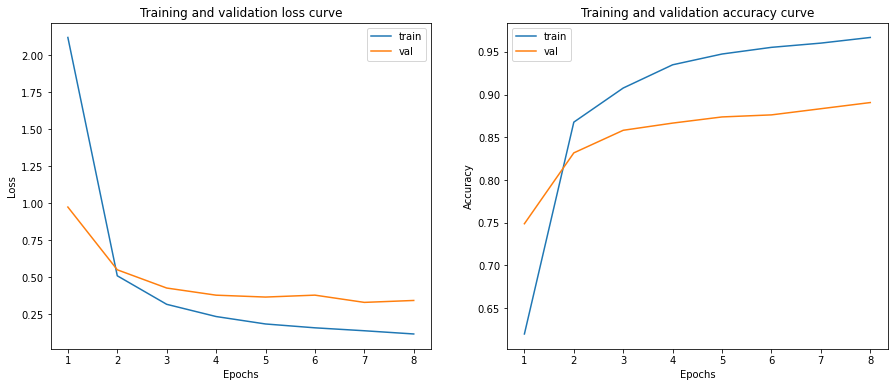

In [20]:
# define callback
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                            min_delta = 0.05, 
                                            patience = 3,
                                            mode = 'auto', 
                                            restore_best_weights = True)
# compile the model
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# fit the model
history = model.fit(train_ds, 
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS, 
                    callbacks = [callback], 
                    validation_data = val_ds)

# plot the loss and accuracy on the training and validation dataset
plot_loss_accuracy(history)

- The model did overfit on the training dataset

### Image data augmentation to avoid overfitting

In [24]:
# define augmentation operations for the training data
trainAug = ImageDataGenerator(rotation_range = 30,
                              shear_range = 0.2,
                              height_shift_range = 0.2,
                              width_shift_range = 0.2,
                              brightness_range = (0.2, 1.0),
                              zoom_range = 0.2,
                              horizontal_flip = True,
                              fill_mode = 'nearest')

# training data generator
trainGen = trainAug.flow_from_dataframe(train_df,
                                        x_col = "file_paths",
                                        y_col = "classes",
                                        target_size = (TARGET_SIZE, TARGET_SIZE),
                                        color_mode = "rgb",
                                        class_mode = "sparse",
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        interpolation = "nearest")

# validation data generator
valAug = ImageDataGenerator()
valGen = valAug.flow_from_dataframe(val_df,
                                    x_col = "file_paths",
                                    y_col = "classes",
                                    target_size = (TARGET_SIZE, TARGET_SIZE),
                                    color_mode = "rgb",
                                    class_mode = "sparse",
                                    batch_size = BATCH_SIZE,
                                    shuffle = True,
                                    interpolation = "nearest")

Found 6659 validated image filenames belonging to 133 classes.
Found 832 validated image filenames belonging to 133 classes.


Epoch 1/50
333/333 [==============================] - 213s 625ms/step - loss: 0.4321 - accuracy: 0.8697 - val_loss: 0.2750 - val_accuracy: 0.9087
Epoch 2/50
333/333 [==============================] - 205s 616ms/step - loss: 0.3530 - accuracy: 0.8889 - val_loss: 0.2680 - val_accuracy: 0.9147
Epoch 3/50
333/333 [==============================] - 205s 616ms/step - loss: 0.3186 - accuracy: 0.9007 - val_loss: 0.2568 - val_accuracy: 0.9147
Epoch 4/50
333/333 [==============================] - 205s 615ms/step - loss: 0.2790 - accuracy: 0.9141 - val_loss: 0.2661 - val_accuracy: 0.9026


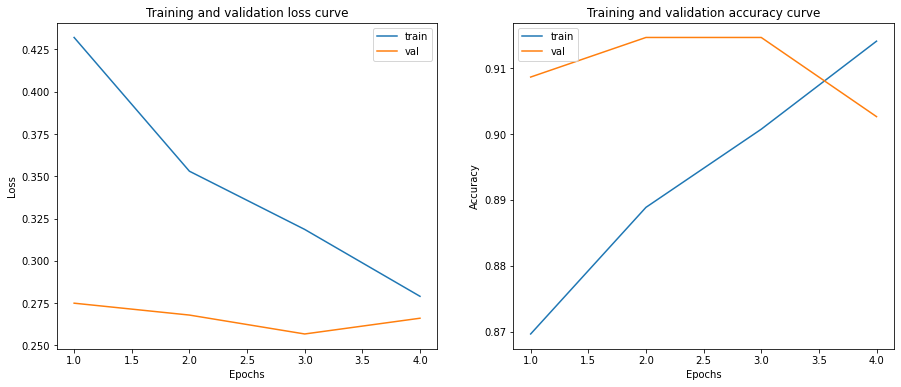

In [25]:
# fit the model with data augmentation
history = model.fit(trainGen, 
                    epochs = EPOCHS,
                    callbacks = [callback],
                    batch_size = BATCH_SIZE,-
                      ``
                    validation_data = valGen)

# plot the loss and accuracy on the training and validation dataset
plot_loss_accuracy(history)

### Fine-tune EfficientNetB4 model


In [26]:
def unfreeze_model(model):
  # unfreeze the top 20 layers while leaving BatchNorm layers frozen
  for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
  model.compile(optimizer = optimizer, 
                loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

Epoch 1/50
333/333 [==============================] - 220s 627ms/step - loss: 0.3194 - accuracy: 0.9022 - val_loss: 0.2573 - val_accuracy: 0.9171
Epoch 2/50
333/333 [==============================] - 207s 623ms/step - loss: 0.2836 - accuracy: 0.9129 - val_loss: 0.2475 - val_accuracy: 0.9267
Epoch 3/50
333/333 [==============================] - 207s 622ms/step - loss: 0.2511 - accuracy: 0.9240 - val_loss: 0.2516 - val_accuracy: 0.9135
Epoch 4/50
333/333 [==============================] - 207s 622ms/step - loss: 0.2335 - accuracy: 0.9257 - val_loss: 0.2392 - val_accuracy: 0.9183


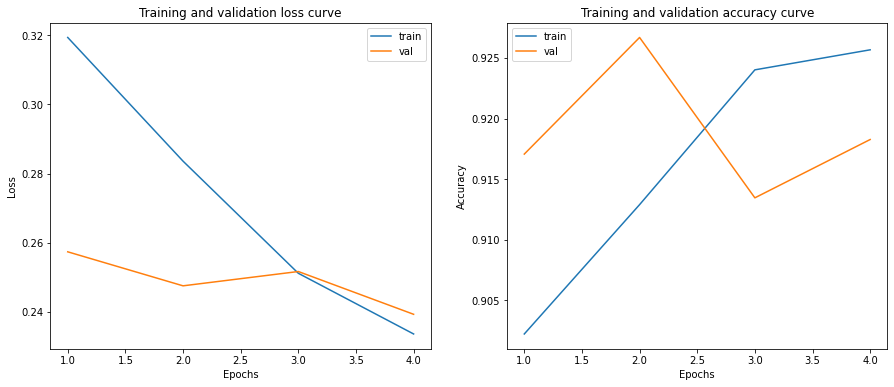

In [27]:
# model finetuning
unfreeze_model(model)

# fit the model with data augmentation
history = model.fit(trainGen, 
                    epochs = EPOCHS,
                    callbacks = [callback],
                    batch_size = BATCH_SIZE,
                    validation_data = valGen)

# plot the loss and accuracy on the training and validation dataset
plot_loss_accuracy(history)

### Evaluate the model performance on the test dataset

In [28]:
def display_confusion_matrix(cmat, score, precision, recall):
  """
  Displays confusion matrix, f1-score, precision and recall on the test dataset

  Args:
    cmat: confusion matrix
    score: f1-score
    precision: precision score
    recall: recall score

  Returns:
    None
  """
  plt.figure(figsize = (15, 15))
  ax = plt.gca()

  ax.matshow(cmat, cmap = 'Reds')
  ax.set_xticks(range(len(CLASS_NAMES)))
  ax.set_xticklabels(CLASS_NAMES, fontdict = {'fontsize': 7})
  plt.setp(ax.get_xticklabels(), rotation = 45, ha = "left", rotation_mode = "anchor")

  ax.set_yticks(range(len(CLASS_NAMES)))
  ax.set_yticklabels(CLASS_NAMES, fontdict = {'fontsize': 7})
  plt.setp(ax.get_yticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

  titlestring = ""
  if score is not None:
    titlestring += 'f1 = {:.3f} '.format(score)
  if precision is not None:
    titlestring += '\nprecision = {:.3f} '.format(precision)
  if recall is not None:
    titlestring += '\nrecall = {:.3f} '.format(recall)
  if len(titlestring) > 0:
    ax.text(101, 1, titlestring, 
            fontdict = {'fontsize': 18, 'horizontalalignment':'right', 
                        'verticalalignment':'top', 'color':'#804040'})
  plt.show()

In [32]:
def true_pred_labels(model, dataset):
  """
  Computes confusion matrix, f1-score, precision and recall on the test dataset

  Args:
    model: tensorflow model
    dataset: test dataset

  Returns:
   cmat: confusion matrix
   score: f1-score
   precision: precision score
   recall: recall score
  """
  y_true = []   # store true labels
  y_pred = []   # store predicted labels

  # iterate over the dataset
  for image_batch, label_batch in dataset:
    # collect label batch
    y_true.append(label_batch)
    # make predictions on image batch
    preds = model.predict(image_batch)
    # store predictions
    y_pred.append(np.argmax(preds, axis = - 1))

  y_true = tf.concat([item for item in y_true], axis = 0)
  y_pred = tf.concat([item for item in y_pred], axis = 0)

  labels = range(len(CLASS_NAMES))

  # compute classification report
  report = classification_report(y_true, y_pred, target_names = CLASS_NAMES)
  print(f'Classification report on test data: \n{report}') 
  
  # compute confusion matrix
  cmat = confusion_matrix(y_true, y_pred)
  cmat = (cmat.T / cmat.sum(axis = 1)).T # normalize

  # compute f1-score, precision and recall
  score = f1_score(y_true, y_pred, average = 'macro')
  precision = precision_score(y_true, y_pred, average = 'macro')
  recall = recall_score(y_true, y_pred, average = 'macro')

  return cmat, score, precision, recall

Classification report on test data: 
                                    precision    recall  f1-score   support

                     Affenpinscher       1.00      0.75      0.86         8
                      Afghan_hound       1.00      1.00      1.00         8
                  Airedale_terrier       0.86      1.00      0.92         6
                             Akita       1.00      0.88      0.93         8
                  Alaskan_malamute       0.91      1.00      0.95        10
               American_eskimo_dog       1.00      0.88      0.93         8
                 American_foxhound       1.00      1.00      1.00         7
    American_staffordshire_terrier       1.00      1.00      1.00         7
            American_water_spaniel       1.00      0.50      0.67         4
            Anatolian_shepherd_dog       1.00      1.00      1.00         6
             Australian_cattle_dog       1.00      1.00      1.00         8
               Australian_shepherd       0.90     

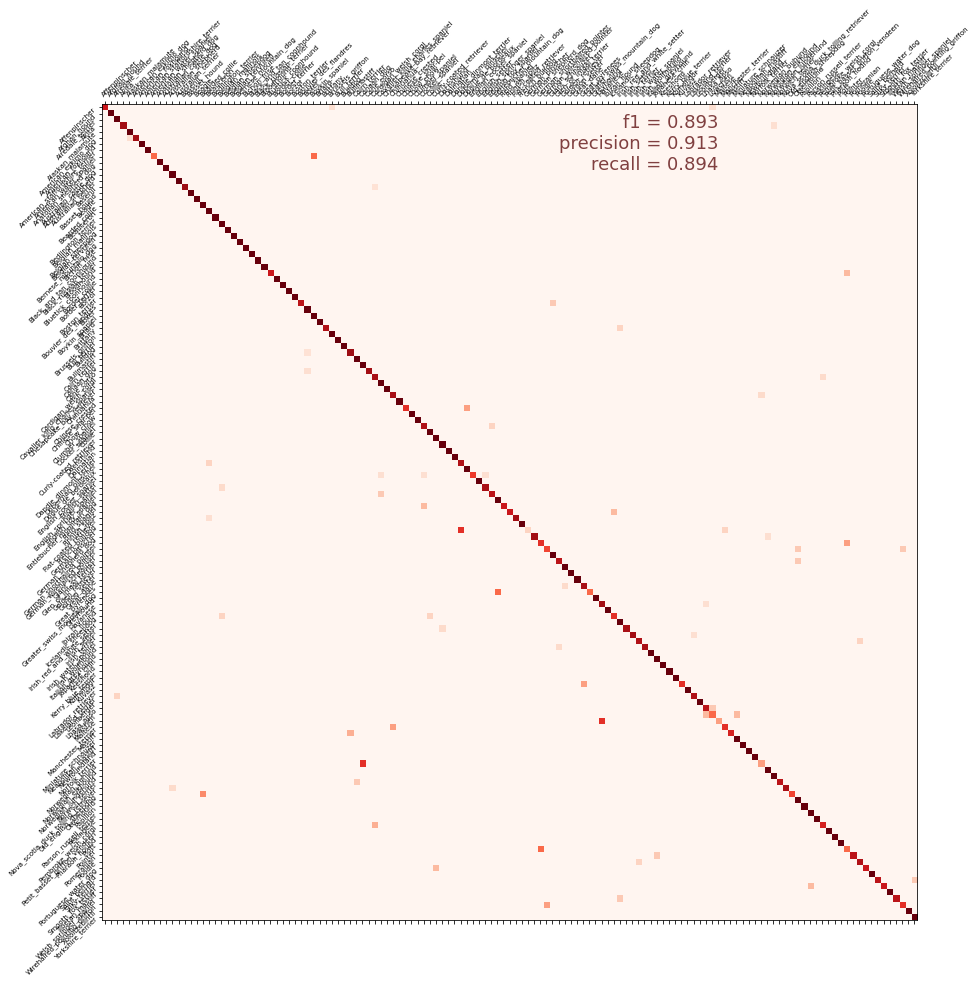

In [33]:
# print confusion matrix, f1-score, precision and recall
cmat, score, precision, recall = true_pred_labels(model, test_ds)

display_confusion_matrix(cmat, score, precision, recall)

In [31]:
# accuracy and loss on test dataset
model.evaluate(test_ds)

42/42 [==============================] - 10s 182ms/step - loss: 0.2953 - accuracy: 0.9075


[0.2952984571456909, 0.9074519276618958]

In [34]:
model.save('/content/drive/MyDrive/Dog Breeds/DogBreedClassifier')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dog Breeds/DogBreedClassifier/assets
